# Bilgisayarla Görme ve OpenCV

> Bu not defteri, [Yeni Başlayanlar için YZ Müfredatı](http://github.com/microsoft/ai-for-beginners)'nın bir parçasıdır.

[OpenCV](https://opencv.org/), görüntü işleme için *fiili* standart olarak kabul edilir. C++ ile gerçekleştirilmiş birçok faydalı algoritma içerir. OpenCV'yi Python'dan da çağırabilirsiniz.

Bu not defterinde size OpenCV kullanımı için bazı örnekler vereceğiz. Daha fazla ayrıntı için [OpenCV Öğrenin](https://learnopencv.com/getting-started-with-opencv/) çevrimiçi kursunu ziyaret edebilirsiniz.

İlk olarak, diğer yararlı kütüphanelerin yanı sıra `cv2`'yi içe aktaralım:

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()


## İmgeleri Yükleme

Python'daki imgeler, NumPy dizilimleriyle uygun şekilde temsil edilebilir. Örneğin, 320x200 piksel boyutunda gri tonlamalı imge 200x320 diziliminde depolanacak ve aynı boyuttaki renkli imge 200x320x3 (3 renk kanalı için) şeklinde olacaktır.

Bir imge yükleyerek başlayalım:

(242, 531, 3)


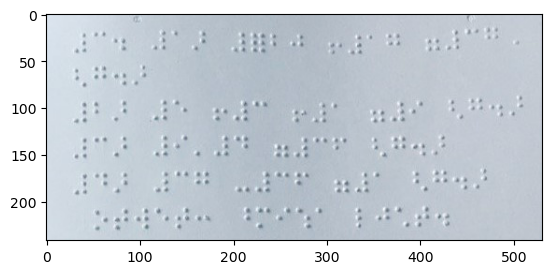

In [2]:
im = cv2.imread('../data/braille.jpeg')
print(im.shape)
plt.imshow(im)

Gördüğünüz gibi, braille metninin bir resmidir. Gerçek renkle pek ilgilenmediğimiz için onu siyah beyaza çevirebiliriz:

(242, 531)


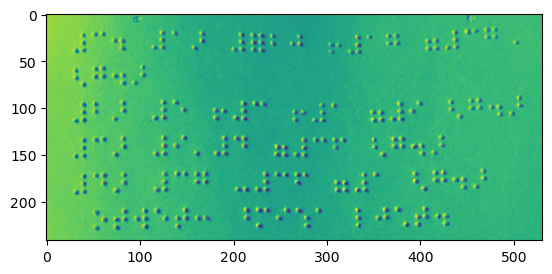

In [3]:
bw_im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
print(bw_im.shape)
plt.imshow(bw_im)

## Braille İmge İşleme

Metni tanımak için imge sınıflandırması uygulamak istiyorsak, daha önce gördüğümüz MNIST imgelerine benzer hale getirmek için tek tek sembolleri kesmemiz gerekir. Bu, daha sonra tartışacağımız [nesne algılama](../../11-ObjectDetection/translations/README.tr.md) tekniği kullanılarak yapılabilir, ancak bunun için saf bilgisayarla görme kullanmayı da deneyebiliriz. Bilgisayarla görmenin karakter ayrımı için nasıl kullanılabileceğine dair iyi bir açıklama [bu blog gönderisinde](https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/) bulunabilir; biz burada sadece bazı bilgisayarla görme tekniklerine odaklanacağız.

İlk olarak, imgeyi biraz zenginleştirmeye çalışalım. **Eşikleme** fikrini kullanabiliriz ([bu OpenCV makalesinde](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) iyi açıklanmıştır):

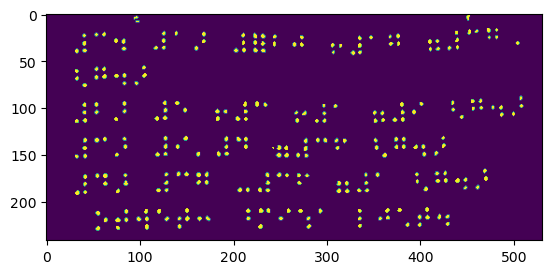

In [4]:
im = cv2.blur(bw_im,(3,3))
im = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                           cv2.THRESH_BINARY_INV, 5, 4)
im = cv2.medianBlur(im, 3)
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
im = cv2.GaussianBlur(im, (3,3), 0)
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
plt.imshow(im)

İmgelerle çalışmak için, tek tek noktaları "çıkarmamız", yani imgeleri tek tek noktaların bir dizi koordinatına dönüştürmemiz gerekir. Bunu SIFT, SURF veya [ORB](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html) gibi **öznitelik çıkarma** teknikleri kullanarak yapabiliriz:

In [5]:
orb = cv2.ORB_create(5000)
f,d = orb.detectAndCompute(im,None)
print(f"İlk 5 nokta: { [f[i].pt for i in range(5)]}")

İlk 5 nokta: [(307.20001220703125, 40.80000305175781), (297.6000061035156, 114.00000762939453), (423.6000061035156, 133.20001220703125), (242.40000915527344, 144.0), (103.68000793457031, 57.60000228881836)]


İşleri doğru yaptığımızdan emin olmak için tüm noktaları çizelim:

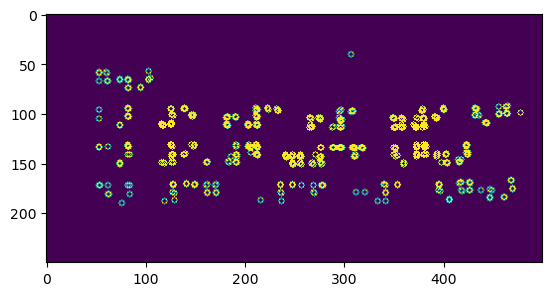

In [6]:
def plot_dots(dots):
    img = np.zeros((250,500))
    for x in dots:
        cv2.circle(img,(int(x[0]),int(x[1])),3,(255,0,0))
    plt.imshow(img)

pts = [x.pt for x in f]
plot_dots(pts)  

Tek tek karakterleri ayırmak için tüm metnin kuşatan kutusunu bilmemiz gerekir. Bunu bulmak için minimum ve maksimum koordinatları hesaplayabiliriz:

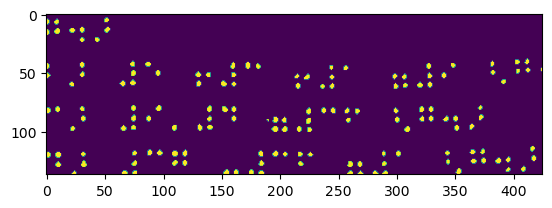

In [7]:
min_x, min_y, max_x, max_y = [int(f([z[i] for z in pts])) for f in (min,max) for i in (0,1)]
min_y+=13
plt.imshow(im[min_y:max_y,min_x:max_x])

Ayrıca, bu metin kısmen döndürülebilir ve mükemmel bir şekilde hizalanması için **perspektif dönüşümü** yapmamız gerekir. $(x_{min},y_{min}), (x_{min},y_{max}), (x_{max},y_{min}), (x_{max},y_{max})$ noktalarıyla tanımlanan bir dikdörtgen alacağız ve orantılı boyutlara sahip yeni imgeyle hizalayacağız:

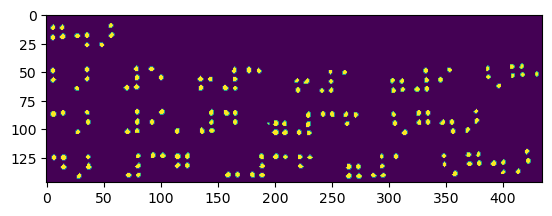

In [8]:
off = 5
src_pts = np.array([(min_x-off,min_y-off),(min_x-off,max_y+off),
                    (max_x+off,min_y-off),(max_x+off,max_y+off)])
w = int(max_x-min_x+off*2)
h = int(max_y-min_y+off*2)
dst_pts = np.array([(0,0),(0,h),(w,0),(w,h)])
ho,m = cv2.findHomography(src_pts,dst_pts)
trim = cv2.warpPerspective(im,ho,(w,h))
plt.imshow(trim)

Bu iyi hizalanmış imgeyi elde ettikten sonra, onu parçalara ayırmak nispeten kolay olmalıdır:

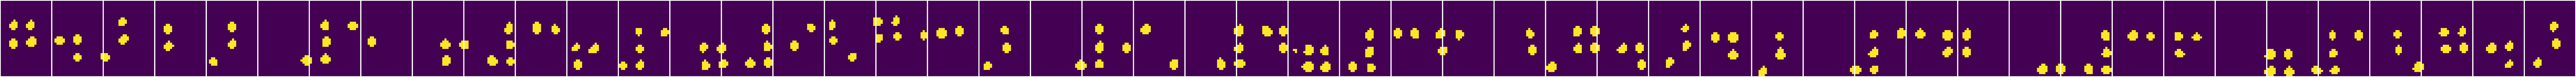

In [9]:
char_h = 36
char_w = 24
def slice(img):
    dy,dx = img.shape
    y = 0
    while y+char_h<dy:
        x=0
        while x+char_w<dx:
            # Skip empty lines
            if np.max(img[y:y+char_h,x:x+char_w])>0:
                yield img[y:y+char_h,x:x+char_w]
            x+=char_w
        y+=char_h

sliced = list(slice(trim))
display_images(sliced)

Herhangi bir yapay zeka olmaksızın saf imge işleme kullanılarak pek çok görevin yapılabileceğini gördünüz. Bir sinir ağının işini daha basit hale getirmek için bilgisayarla görme tekniklerini kullanabilirsek - kesinlikle yapmalıyız çünkü bu, daha az sayıda eğitim verisi ile sorunları çözmemize izin verecektir.

## Kare Farkını Kullanarak Hareket Algılama

Video akışında hareket algılama çok sık yapılan bir uğraştır. Örneğin, güvenlik kamerasında bir şey olduğunda uyarı almamızı sağlar. Kamerada neler olup bittiğini anlamak istiyorsak, bir sinir ağı kullanabiliriz; ancak bir şeylerin döndüğünü bildiğimizde sinir ağını kullanmak çok daha ucuzdur.

Hareket algılamanın ana fikri basittir. Kamera sabitlenirse, kameradan alınan kareler birbirine oldukça benzer olmalıdır. Kareler dizilimler olarak temsil edildiğinden, yalnızca bu dizilimleri sonraki iki kare için çıkararak, durağan kareler için düşük olması gereken ve imgede önemli bir hareket olduğunda daha yüksek olması gereken piksel farkını elde ederiz.

Bir videoyu nasıl açacağımızı öğrenerek başlayacağız ve onu bir dizi kareye dönüştüreceğiz:

Total frames: 876


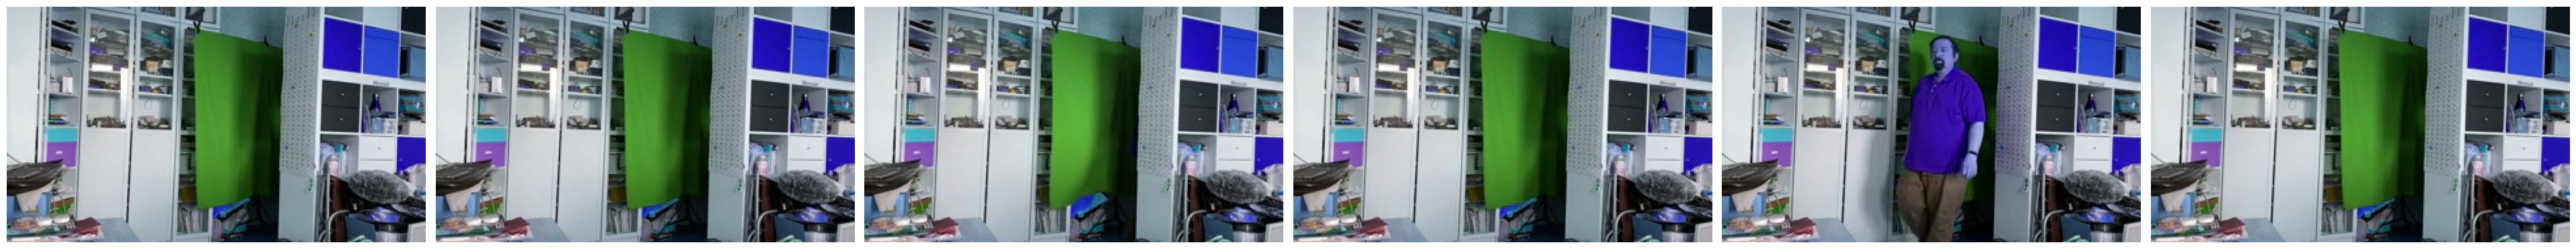

In [10]:
vid = cv2.VideoCapture('../data/motionvideo.mp4')

c = 0
frames = []
while vid.isOpened():
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)
    c+=1
vid.release()
print(f"Total frames: {c}")
display_images(frames[::150])

Hareket algılama için renk çok önemli olmadığından tüm kareleri gri tonlamaya dönüştüreceğiz. Ardından, kare farklarını hesaplayacağız ve devam eden aktivite miktarını görsel olarak görmek için normlarını çizeceğiz:

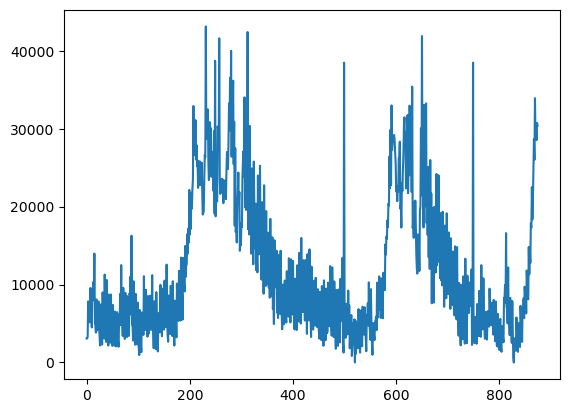

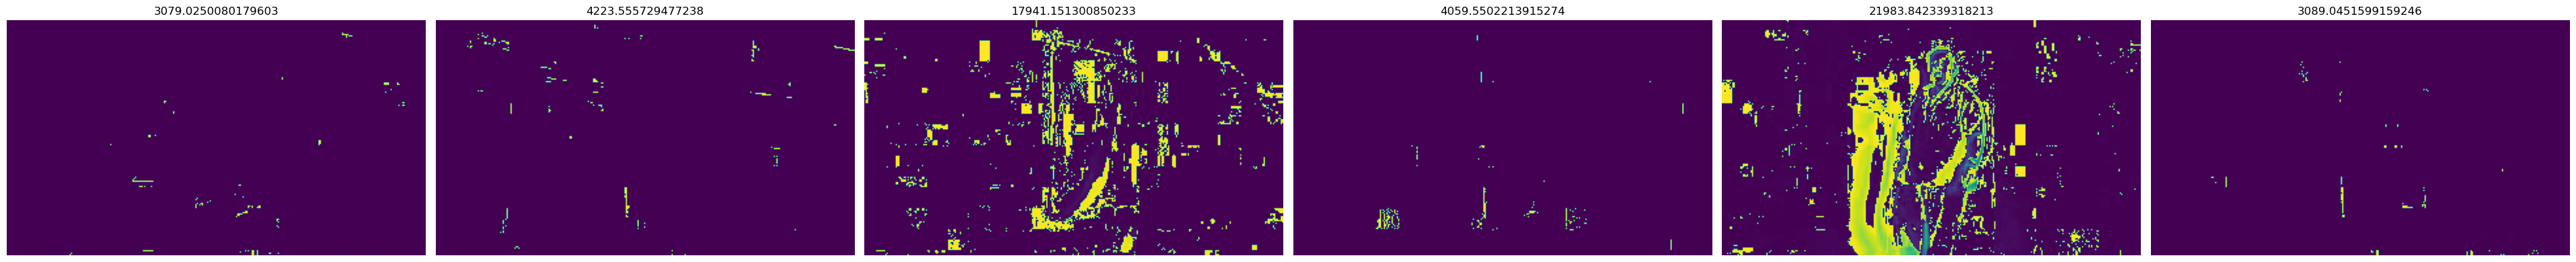

In [11]:
bwframes = [cv2.cvtColor(x,cv2.COLOR_BGR2GRAY) for x in frames]
diffs = [(p2-p1) for p1,p2 in zip(bwframes[:-1],bwframes[1:])]
diff_amps = np.array([np.linalg.norm(x) for x in diffs])
plt.plot(diff_amps)
display_images(diffs[::150],titles=diff_amps[::150])

Her olay olduğunda uygun imgeyi göstererek kamera önünde olanları gösteren bir rapor oluşturmak istediğimizi varsayalım. Bunu yapmak için muhtemelen bir "olay"ın başlangıç ve bitiş karesini bulmak ve orta kareyi görüntülemek istiyoruz. Biraz gürültüyü gidermek için, yukarıdaki eğriyi hareketli ortalama işleviyle de düzelteceğiz:

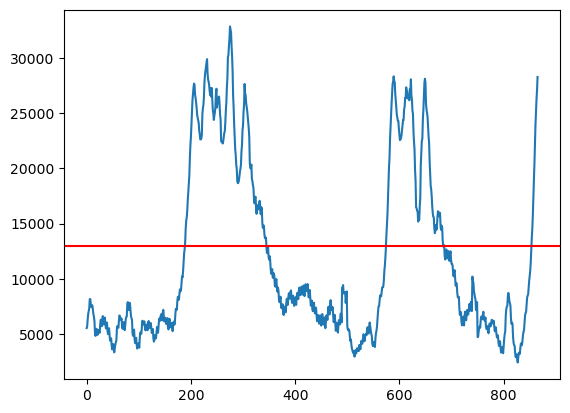

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

threshold = 13000

plt.plot(moving_average(diff_amps,10))
plt.axhline(y=threshold, color='r', linestyle='-')

Şimdi `np.where` kullanarak eşiğin üzerinde değişiklik miktarına sahip kareleri bulabilir ve 30 kareden uzun ardışık kare dizisini çıkartabiliriz:

In [13]:
active_frames = np.where(diff_amps>threshold)[0]

def subsequence(seq,min_length=30):
    ss = []
    for i,x in enumerate(seq[:-1]):
        ss.append(x)
        if x+1 != seq[i+1]:
            if len(ss)>min_length:
                return ss
            ss.clear()

sub = subsequence(active_frames)
print(sub)


[195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322]


Ve son olarak imgeyi gösterebiliriz:

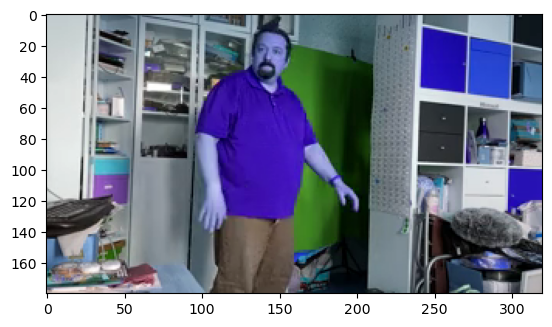

In [14]:
plt.imshow(frames[(sub[0]+sub[-1])//2])

Bu imgedeki renk şemasının doğru görünmediğini fark edebilirsiniz! Bunun nedeni, OpenCV'nin tarihsel nedenlerle imgeleri BGR renk uzayında yüklemesi, matplotlib'in ise daha geleneksel RGB renk düzeni kullanmasıdır. Çoğu zaman, imgeleri yükledikten hemen sonra RGB'ye dönüştürmek mantıklıdır.

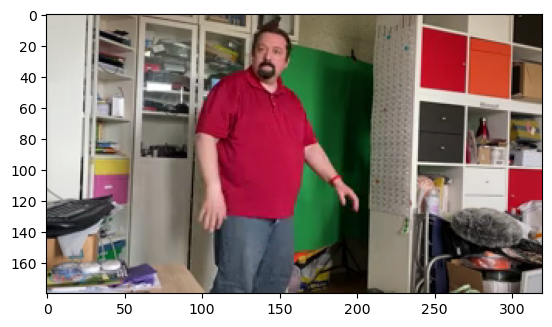

In [15]:
plt.imshow(cv2.cvtColor(frames[(sub[0]+sub[-1])//2],cv2.COLOR_BGR2RGB))

## Optik Akışı Kullanarak Hareketi Çıkarma

Ardışık iki kareyi karşılaştırmak sadece değişim miktarını görmemizi sağlarken gerçekte neyin nerede hareket ettiğine dair herhangi bir bilgi vermez. Bu bilgiyi elde etmek için **[optik akış](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html)** adlı bir teknik vardır:

* **Yoğun Optik Akış**, her pikselin nerede hareket ettiğini gösteren vektör alanını hesaplar.
* **Seyrek Optik Akış**, imgedeki bazı ayırt edici özniteliklerin (örn. kenarlar) alınmasına ve kareden kareye yörüngelerinin oluşturulmasına dayanır.

[Bu harika eğitimde](https://learnopencv.com/optical-flow-in-opencv/) optik akış hakkında daha fazla bilgi edinebilirsiniz.

Karelerimiz arasındaki yoğun optik akışı hesaplayalım:

In [16]:
flows = [cv2.calcOpticalFlowFarneback(f1, f2, None, 0.5, 3, 15, 3, 5, 1.2, 0) 
         for f1,f2 in zip(bwframes[:-1],bwframes[1:])]
flows[0].shape

(180, 320, 2)

Görüldüğü gibi her bir kare için akış, kare boyutuna ve optik akış vektörünün x ve y bileşenlerine karşılık gelen 2 kanala sahiptir.

Optik akışı 2B olarak göstermek biraz zordur, ancak zekice bir fikir kullanabiliriz. Optik akışı kutupsal koordinatlara çevirirsek, her piksel için iki bileşen elde ederiz: *Yön* ve *yoğunluk*. Yoğunluğu piksel yoğunluğuyla ve yönü farklı renklerle temsil edebiliriz. [HSV (Ton-Doygunluk-Değer) renk uzayında](https://en.wikipedia.org/wiki/HSV_color_space) bir imge oluşturacağız; burada ton yön, değer - yoğunluk ve doygunluk ise 255 olsun.

195 322


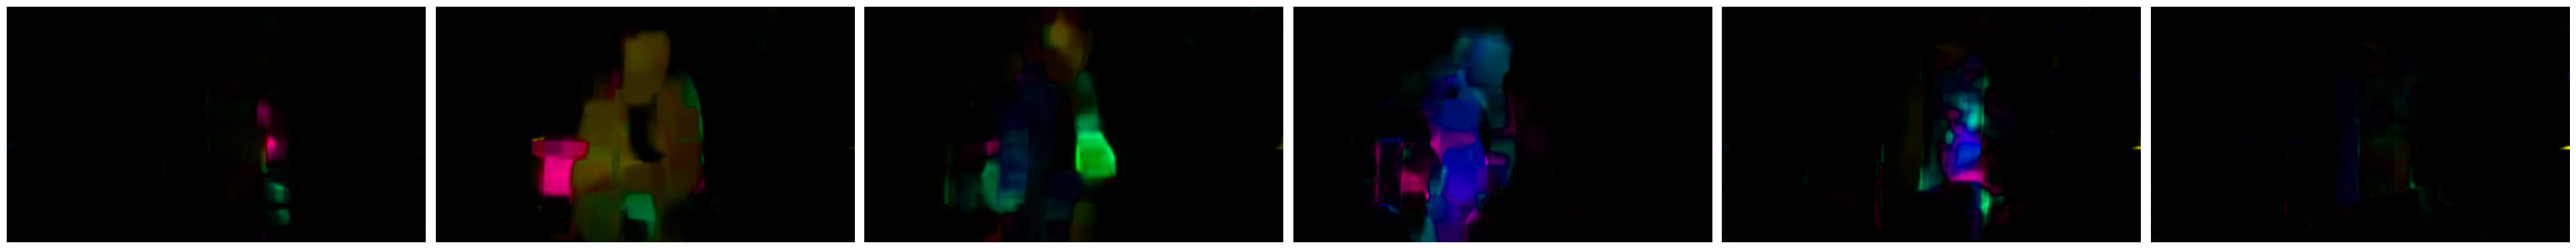

In [17]:
def flow_to_hsv(flow):
    hsvImg = np.zeros((flow.shape[0],flow.shape[1],3),dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)

start = sub[0]
stop = sub[-1]
print(start,stop)

frms = [flow_to_hsv(x) for x in flows[start:stop]]
display_images(frms[::25])

Yani, bu karelerde yeşilimsi renk sola hareket etmeye karşılık gelirken, mavi sağa hareket etmeye karşılık gelir.

Optik akış, genel hareket yönü hakkında sonuçlar çıkarmak için harika bir araç olabilir. Örneğin, bir karedeki tüm piksellerin aşağı yukarı aynı yönde hareket ettiğini görürseniz, kamera hareketi olduğu sonucuna varabilir ve bunu denkleştirmeye çalışabilirsiniz.